# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [155]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?
> 10,496

Question 2: How much memory does the graphics card have?
> 24GB

Question 3: What is stored in the GPU memory while training a DNN?
> Current batch data, weight/parameter values, current forward and backward propagation values

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [1]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates (columns)
X = X[:, 24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
class_counts = np.unique(Y, return_counts=True)

print()
for class_i in range(len(class_counts[0])):
    print(f"Number of class {class_counts[0][class_i]}: {class_counts[1][class_i]}")

The covariates have size (764137, 92).
The labels have size (764137,).

Number of class 0.0: 121621
Number of class 1.0: 642516


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [2]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
print(f"Number of NaNs in Y: {np.sum(np.isnan(Y))}")

# Print the number of NaNs in the covariates
print(f"Number of NaNs in X: {np.sum(np.isnan(X))}")

Number of NaNs in Y: 0
Number of NaNs in X: 0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [3]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to integers
Y = Y.astype(int)

# Remove mean of each covariate (column)
means = np.mean(X, axis=0, keepdims=True)
# means = means.repeat(X.shape[0], axis=0)

stds = np.std(X, axis=0).reshape(-1, X.shape[1])
stds = stds.repeat(X.shape[0], axis=0)

X = X - means

# Divide each covariate (column) by its standard deviation
X = X / stds

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("Column means:\n")
print(np.mean(X, axis=0))
print("\nColumn stds:\n")
print(np.std(X, axis=0))

Column means:

[-3.19451533e-18 -6.30927527e-14  1.19963828e-13  4.56743018e-15
  4.08813918e-14  1.46461039e-13  5.65402045e-16 -1.69587525e-14
 -3.03376191e-13  1.25514109e-12 -2.72042402e-12 -1.10780892e-13
 -1.22468718e-13 -1.70290612e-13 -1.02139901e-14 -2.32208048e-12
  1.40695736e-12  1.20673259e-12 -1.05095447e-13  6.81889584e-14
 -1.00490973e-13  5.98862427e-14 -1.01547416e-12 -1.66283323e-12
 -1.58597771e-12 -1.31674067e-13  4.43360813e-13  8.41389037e-13
  5.77665264e-14 -4.50766872e-13 -2.54973195e-12  3.12056823e-13
 -1.53665212e-13  1.69273859e-12  9.50945604e-13  1.50953004e-13
 -1.01059397e-12 -5.11453792e-13 -1.86373908e-12 -2.09806690e-13
  1.03169903e-12 -1.47389966e-12 -1.69587525e-14 -1.64918984e-16
 -5.13325984e-14 -1.02166240e-14 -1.74685907e-15  1.34329189e-13
  5.98601714e-14  1.48745574e-17 -4.24927612e-13  5.77728088e-14
  1.25638129e-15  1.71850347e-13  1.50955720e-13  2.14478905e-14
  3.65405571e-14  1.21380412e-13 -9.10989074e-13 -6.30800138e-13
 -1.580386

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [4]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
train_class_counts = np.unique(Ytrain, return_counts=True)
temp_class_counts = np.unique(Ytemp, return_counts=True)

print("\nTraining data:")
for class_i in range(len(train_class_counts[0])):
    print(f"Number of class {train_class_counts[0][class_i]}: {train_class_counts[1][class_i]}")

print("\nTemp data:")
for class_i in range(len(temp_class_counts[0])):
    print(f"Number of class {temp_class_counts[0][class_i]}: {temp_class_counts[1][class_i]}")

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).

Training data:
Number of class 0: 85093
Number of class 1: 449802

Temp data:
Number of class 0: 36528
Number of class 1: 192714


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [11]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [12]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == "sgd":
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function    
    # Add first layer, requires input shape
    model.add(Input(shape=input_shape))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))

        if use_bn:
            model.add(BatchNormalization())

        if use_dropout:
            model.add(Dropout(rate=0.5))
        elif use_custom_dropout:
            model.add(myDropout(rate=0.5))
           
    # Add final layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile model
    model.compile(loss=BinaryCrossentropy(), optimizer=opt, metrics=["accuracy"])
    
    return model

In [13]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [14]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (Xtrain.shape[1],)

# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20)

# Train the model, provide training data and validation data
history1 = model1.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs)

Epoch 1/20


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8500 - loss: 0.5747 - val_accuracy: 0.8421 - val_loss: 0.4525
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8419 - loss: 0.4308 - val_accuracy: 0.8405 - val_loss: 0.3832
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.3711 - val_accuracy: 0.8408 - val_loss: 0.3433
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8422 - loss: 0.3346 - val_accuracy: 0.8441 - val_loss: 0.3151
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.3089 - val_accuracy: 0.8534 - val_loss: 0.2937
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.2885 - val_accuracy: 0.8606 - val_loss: 0.2770
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8619 - loss: 0.2733 - val_accuracy: 0.8652 - val_loss: 0.2637
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8653 - loss: 0.2605 - val_accuracy: 0.8681 - val_loss: 0.2530
Epo

In [15]:
# Evaluate the model on the test data
score = model1.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

 419/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.8968 - loss: 0.2033

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - accuracy: 0.8977 - loss: 0.2029
Test loss: 0.2029
Test accuracy: 0.8977


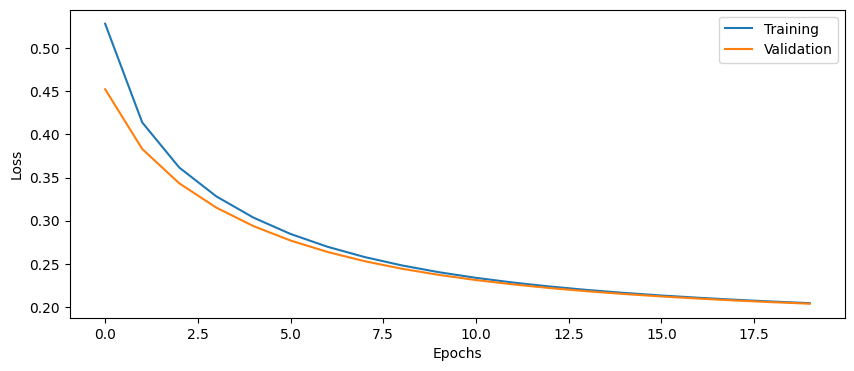

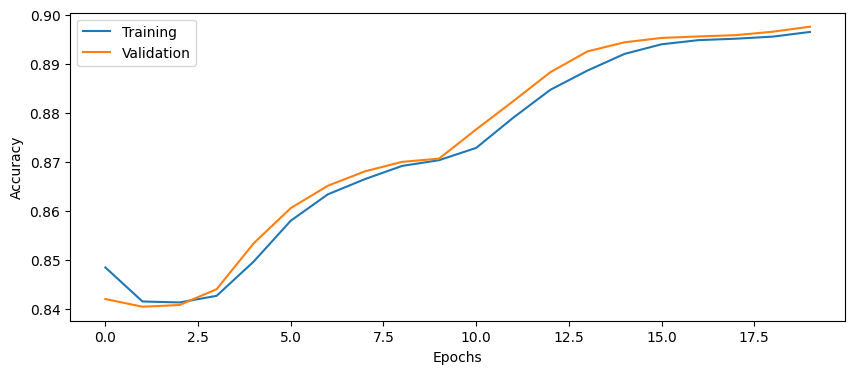

In [16]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

#### Question 5: What happens if you add several Dense layers without specifying the activation function?

The model will be linear, and adding more layers doesn't add more complexity. Mathematically it will reduce to a linear regression model.

#### Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?
By default in the Dense layers in Keras, bias weights are initialized as zero and kernel weights are initialized using the Glorot uniform initializer. The Glorot uniform initializer "draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units)."

Source: https://keras.io/api/layers/initializers/

# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [17]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Ytrain)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                1: class_weights[1]}


[3.14146817 0.59464434]


### 2 layers, 20 nodes, class weights

In [18]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20)

history2 = model2.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1593 - loss: 0.9549 - val_accuracy: 0.1599 - val_loss: 0.9781
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1721 - loss: 0.6323 - val_accuracy: 0.8427 - val_loss: 0.6636
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.5034 - val_accuracy: 0.8805 - val_loss: 0.5260
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8817 - loss: 0.4374 - val_accuracy: 0.8842 - val_loss: 0.4539
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8846 - loss: 0.3942 - val_accuracy: 0.8857 - val_loss: 0.4100
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8858 - loss: 0.3633 - val_accuracy: 0.8860 - val_loss: 0.3802
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8865 - loss: 0.3373 - val_accuracy: 0.8858 - val_loss: 0.3588
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8857 - loss: 0.3175 - val_accuracy: 0.8857 - val_loss:

In [19]:
# Evaluate model on test data
score = model2.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

  96/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.8828 - loss: 0.2896 

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - accuracy: 0.8868 - loss: 0.2801
Test loss: 0.2807
Test accuracy: 0.8865


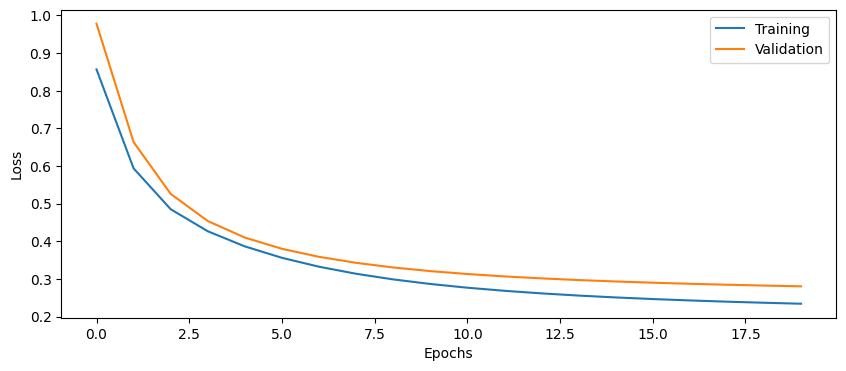

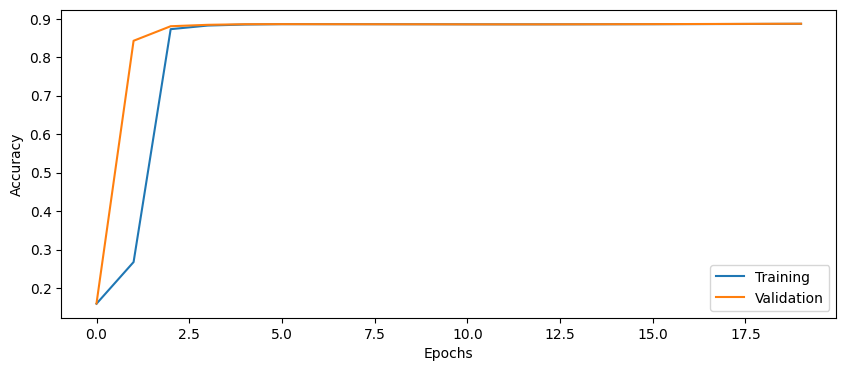

In [20]:
plot_results(history2)

In [21]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 20)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,883 (7.36 KB)

 Trainable params: 1,881 (7.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

#### Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

When using really large datasets, the data can often not be fit fully into GPU (or even CPU) memory. Even if it does, it might be too slow to train on the entire dataset in each epoch. We must then use batches of data to train the model instead. The batch size may depend on how much data we can fit in memory.

#### Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

#### Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

#### Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

If the training data has 534895 rows. The weights are updated 534895 / 100 = 5349 times if the batch size is 100. If the batch size is 1000, the weights are updated 534895 / 1000 = 535 times. If the batch size is 10,000, the weights are updated 534895 / 10,000 = 54 times.

#### Question 11: What limits how large the batch size can be?

The memory capacity of the GPU or CPU, and the size of the data.

#### Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

If the batch size is lower, there is more variation in each pass of the data, so we will want to use a smaller learning rate. 

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

#### Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()
The initial network has 1,881 trainable paramaters.

### 4 layers, 20 nodes, class weights

In [22]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=20)

history3 = model3.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1598 - loss: 0.7141 - val_accuracy: 0.1599 - val_loss: 0.7673
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1582 - loss: 0.6954 - val_accuracy: 0.1599 - val_loss: 0.7238
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1580 - loss: 0.6919 - val_accuracy: 0.1566 - val_loss: 0.7056
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1566 - loss: 0.6926 - val_accuracy: 0.1632 - val_loss: 0.6975
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1703 - loss: 0.6898 - val_accuracy: 0.1809 - val_loss: 0.6941
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3918 - loss: 0.6893 - val_accuracy: 0.8655 - val_loss: 0.6921
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 0.6901 - val_accuracy: 0.8704 - val_loss: 0.6906
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8712 - loss: 0.6910 - val_accuracy: 0.8743 - val_loss: 0.6892
Epo

In [23]:
# Evaluate model on test data
score = model3.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

  96/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - accuracy: 0.8798 - loss: 0.6784 

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.8849 - loss: 0.6782
Test loss: 0.6782
Test accuracy: 0.8842


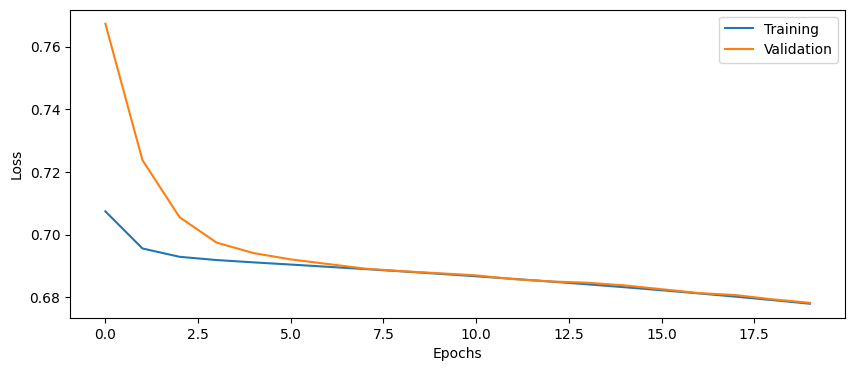

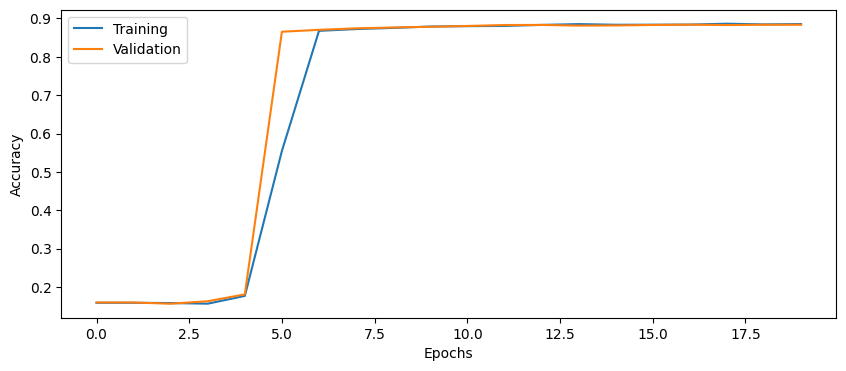

In [24]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=50)

history4 = model4.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8478 - loss: 0.6173 - val_accuracy: 0.8762 - val_loss: 0.5160
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8771 - loss: 0.4879 - val_accuracy: 0.8795 - val_loss: 0.4615
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8786 - loss: 0.4207 - val_accuracy: 0.8793 - val_loss: 0.4140
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8796 - loss: 0.3736 - val_accuracy: 0.8795 - val_loss: 0.3803
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8799 - loss: 0.3409 - val_accuracy: 0.8798 - val_loss: 0.3561
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8796 - loss: 0.3167 - val_accuracy: 0.8799 - val_loss: 0.3394
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8808 - loss: 0.2981 - val_accuracy: 0.8801 - val_loss: 0.3267
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8801 - loss: 0.2851 - val_accuracy: 0.8803 - val_loss:

In [26]:
# Evaluate model on test data
score = model4.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

  91/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.8778 - loss: 0.2906 

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 459us/step - accuracy: 0.8835 - loss: 0.2765
Test loss: 0.2770
Test accuracy: 0.8833


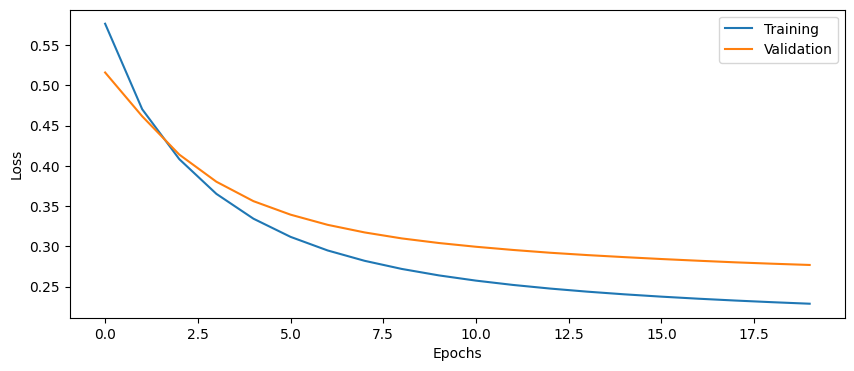

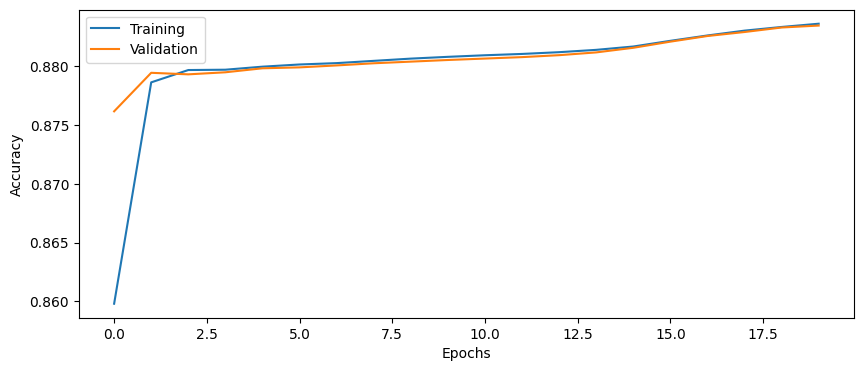

In [27]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50)

history5 = model5.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8411 - loss: 0.7300 - val_accuracy: 0.8401 - val_loss: 0.6678
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8391 - loss: 0.6934 - val_accuracy: 0.8371 - val_loss: 0.6874
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8336 - loss: 0.6904 - val_accuracy: 0.8326 - val_loss: 0.6890
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8350 - loss: 0.6888 - val_accuracy: 0.8463 - val_loss: 0.6874
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8479 - loss: 0.6881 - val_accuracy: 0.8435 - val_loss: 0.6876
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - loss: 0.6858 - val_accuracy: 0.8645 - val_loss: 0.6847
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8670 - loss: 0.6841 - val_accuracy: 0.8598 - val_loss: 0.6842
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8646 - loss: 0.6829 - val_accuracy: 0.8677 - val_loss

In [29]:
# Evaluate model on test data
score = model5.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

 160/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.8754 - loss: 0.6557

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 503us/step - accuracy: 0.8784 - loss: 0.6554
Test loss: 0.6554
Test accuracy: 0.8784


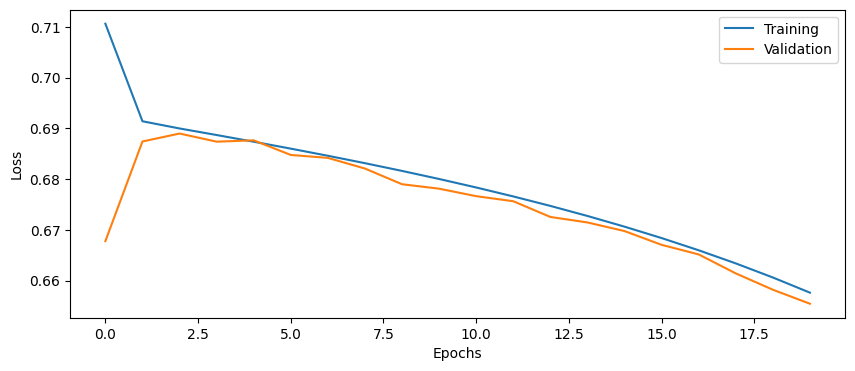

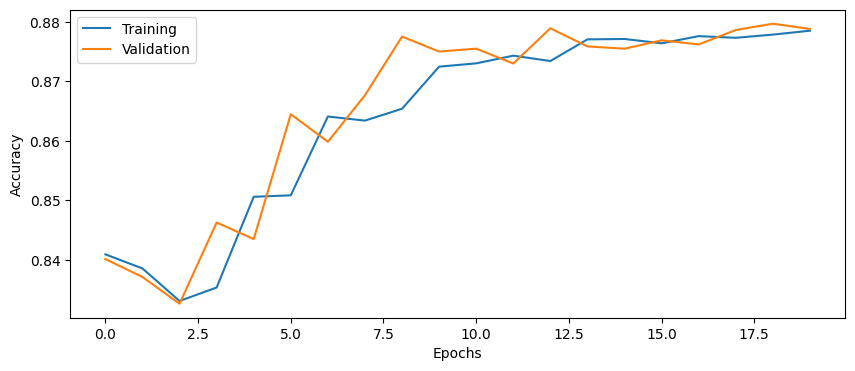

In [30]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

#### Question 14: Why is batch normalization important when training deep networks?
Why it works is not really known, but adding batch normalization makes the model converge faster.

### 2 layers, 20 nodes, class weights, batch normalization

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, use_bn=True)

history6 = model6.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8697 - loss: 0.4527 - val_accuracy: 0.8134 - val_loss: 0.6863
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8795 - loss: 0.3368 - val_accuracy: 0.8729 - val_loss: 0.5688
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.3129 - val_accuracy: 0.8837 - val_loss: 0.4826
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8828 - loss: 0.2943 - val_accuracy: 0.8874 - val_loss: 0.4200
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8856 - loss: 0.2799 - val_accuracy: 0.8893 - val_loss: 0.3770
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8873 - loss: 0.2682 - val_accuracy: 0.8904 - val_loss: 0.3502
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.2592 - val_accuracy: 0.8927 - val_loss: 0.3349
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.2520 - val_accuracy: 0.8959 - val_loss:

In [32]:
# Evaluate model on test data
score = model6.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

  95/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.8956 - loss: 0.2907 

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.9050 - loss: 0.2734
Test loss: 0.2738
Test accuracy: 0.9048


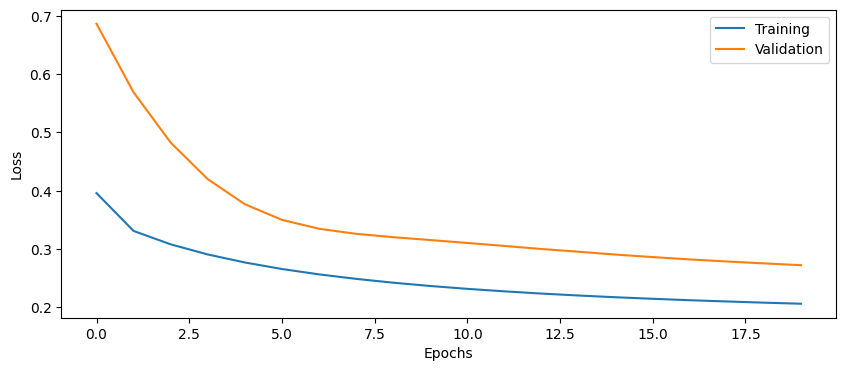

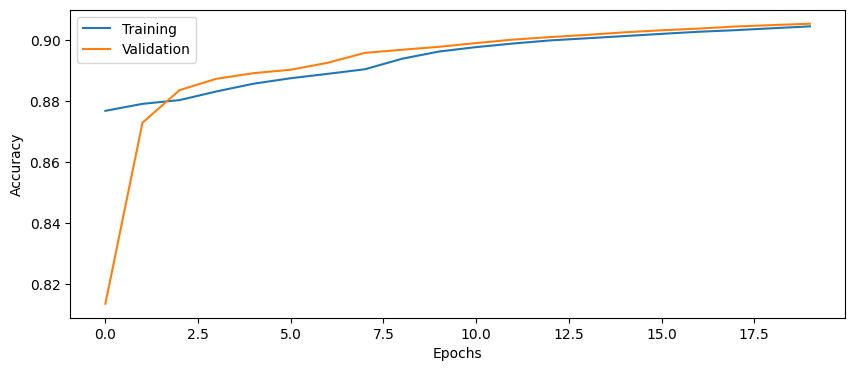

In [33]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [34]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun="relu")

history7 = model7.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5527 - loss: 0.7074 - val_accuracy: 0.8767 - val_loss: 0.4776
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8766 - loss: 0.3722 - val_accuracy: 0.8790 - val_loss: 0.4185
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8785 - loss: 0.3078 - val_accuracy: 0.8798 - val_loss: 0.3805
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8802 - loss: 0.2764 - val_accuracy: 0.8804 - val_loss: 0.3525
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.2594 - val_accuracy: 0.8807 - val_loss: 0.3325
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8808 - loss: 0.2481 - val_accuracy: 0.8809 - val_loss: 0.3177
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.2390 - val_accuracy: 0.8812 - val_loss: 0.3066
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8815 - loss: 0.2328 - val_accuracy: 0.8814 - val_loss:

In [35]:
# Evaluate model on test data
score = model7.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

 194/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.8817 - loss: 0.2607

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - accuracy: 0.8849 - loss: 0.2575
Test loss: 0.2591
Test accuracy: 0.8847


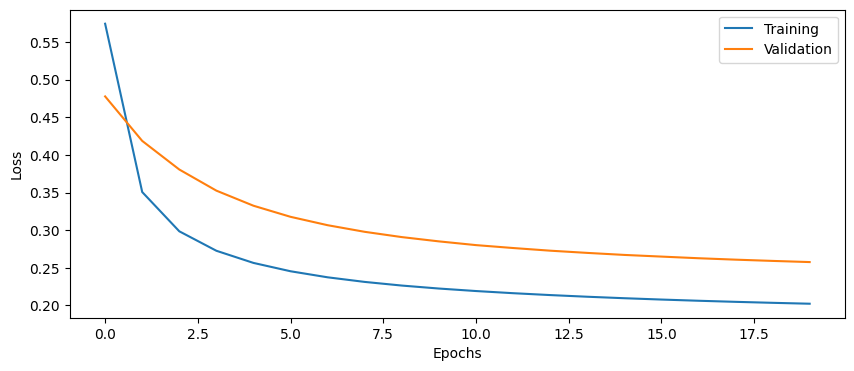

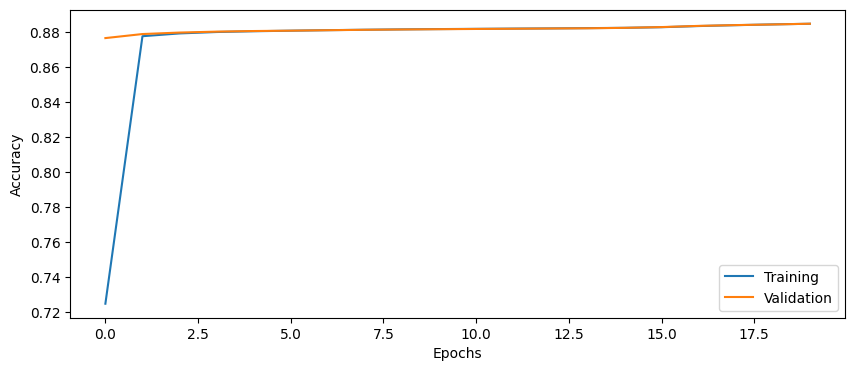

In [36]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, optimizer="adam")

history8 = model8.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8137 - loss: 0.3907 - val_accuracy: 0.8891 - val_loss: 0.2562
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.1967 - val_accuracy: 0.9062 - val_loss: 0.2310
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9074 - loss: 0.1819 - val_accuracy: 0.9099 - val_loss: 0.2248
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9101 - loss: 0.1763 - val_accuracy: 0.9141 - val_loss: 0.2180
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9139 - loss: 0.1726 - val_accuracy: 0.9152 - val_loss: 0.2148
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9154 - loss: 0.1684 - val_accuracy: 0.9156 - val_loss: 0.2131
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9148 - loss: 0.1672 - val_accuracy: 0.9158 - val_loss: 0.2130
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.1645 - val_accuracy: 0.9161 - val_loss:

In [38]:
# Evaluate model on test data
score = model8.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

 173/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.9131 - loss: 0.2013

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 547us/step - accuracy: 0.9182 - loss: 0.1892
Test loss: 0.1891
Test accuracy: 0.9180


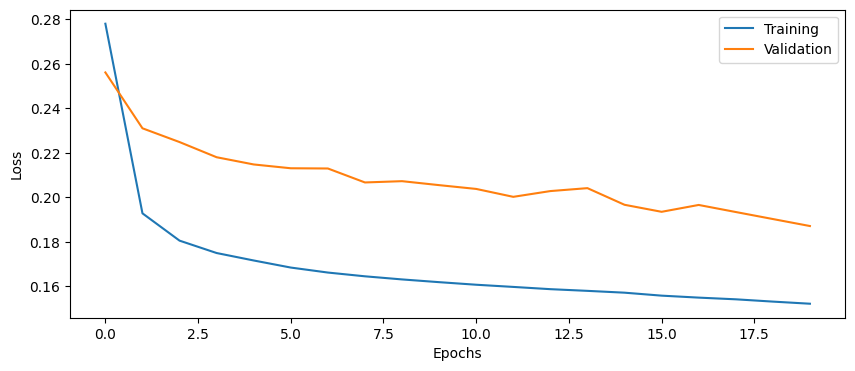

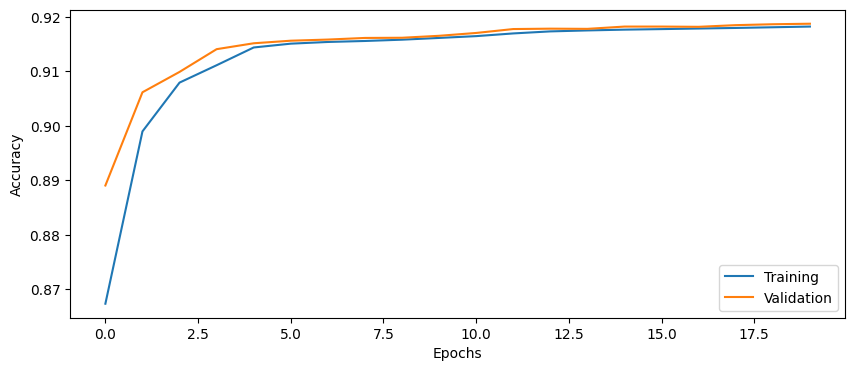

In [39]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

#### Question 15: How does the validation accuracy change when adding dropout?
The validation accuracy is now slightly higher than the training accuracy, whereas before it was either the same or lower, though the differences are small.

#### Question 16: How does the test accuracy change when adding dropout?
The test accuracy stays roughly the same as before. 

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (X.shape[1],)

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, use_dropout=True)

history9 = model9.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5505 - loss: 0.7254 - val_accuracy: 0.8754 - val_loss: 0.5687
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6607 - loss: 0.5911 - val_accuracy: 0.8786 - val_loss: 0.4941
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - loss: 0.5137 - val_accuracy: 0.8787 - val_loss: 0.4418
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.4638 - val_accuracy: 0.8790 - val_loss: 0.4047
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8059 - loss: 0.4284 - val_accuracy: 0.8791 - val_loss: 0.3775
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8227 - loss: 0.4025 - val_accuracy: 0.8794 - val_loss: 0.3574
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.3830 - val_accuracy: 0.8801 - val_loss: 0.3417
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.3662 - val_accuracy: 0.8807 - val_loss:

In [41]:
# Evaluate model on test data
score = model9.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

  99/3582 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.8817 - loss: 0.2849 

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.8858 - loss: 0.2749
Test loss: 0.2754
Test accuracy: 0.8853


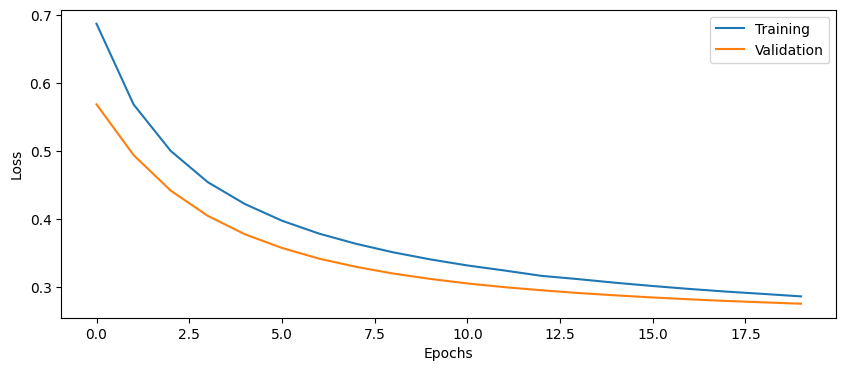

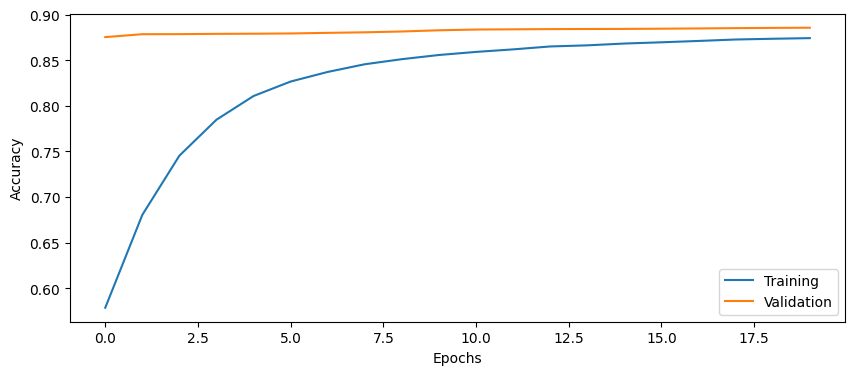

In [42]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

In [43]:
# Find your best configuration for the DNN
# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, optimizer="adam", act_fun="relu", use_bn=True, use_dropout=True)

history10 = model10.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8266 - loss: 0.4402 - val_accuracy: 0.9124 - val_loss: 0.2625
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9102 - loss: 0.2121 - val_accuracy: 0.9162 - val_loss: 0.1591
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9137 - loss: 0.1871 - val_accuracy: 0.9166 - val_loss: 0.1588
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9142 - loss: 0.1798 - val_accuracy: 0.9171 - val_loss: 0.1656
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9153 - loss: 0.1754 - val_accuracy: 0.9169 - val_loss: 0.1656
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9163 - loss: 0.1730 - val_accuracy: 0.9173 - val_loss: 0.1849
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9162 - loss: 0.1711 - val_accuracy: 0.9173 - val_loss: 0.1891
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9156 - loss: 0.1712 - val_accuracy: 0.9171 - v

In [44]:
# Evaluate DNN on test data
score = model10.evaluate(x=Xtest, y=Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

 221/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 687us/step - accuracy: 0.9132 - loss: 0.1957

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step - accuracy: 0.9178 - loss: 0.1877
Test loss: 0.1882
Test accuracy: 0.9178


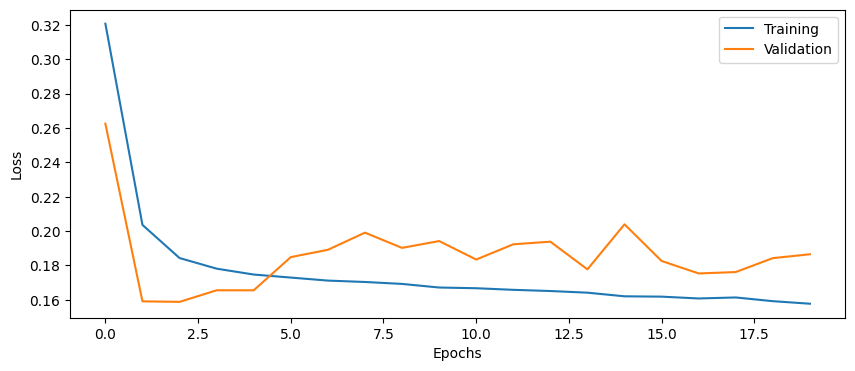

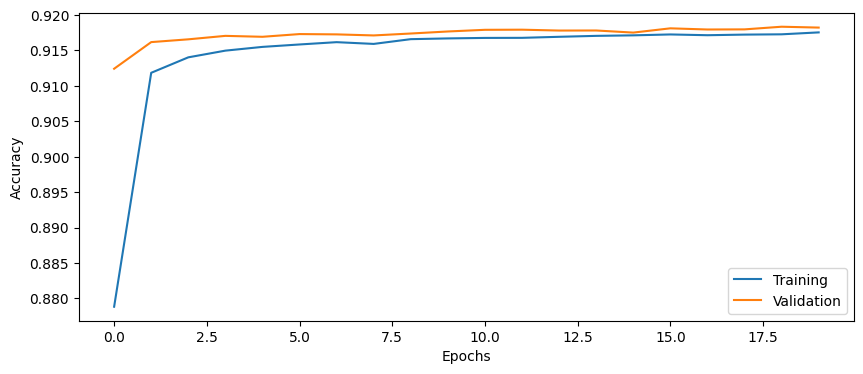

In [45]:
plot_results(history10)

# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

In [51]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [47]:
# Your best training parameters
# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, optimizer="adam", act_fun="relu", use_bn=True, use_custom_dropout=True)

history11 = model11.fit(x=Xtrain, y=Ytrain, validation_data=(Xval, Yval), batch_size=batch_size, epochs=epochs, class_weight=class_weights)

Epoch 1/20


AttributeError: Exception encountered when calling myDropout.call().

[1m'myDropout' object has no attribute 'tf'[0m

Arguments received by myDropout.call():
  • inputs=tf.Tensor(shape=(None, 50), dtype=float32)
  • training=True

In [ ]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(x=Xtest, y=Ytest)
                       
print('Test accuracy: %.4f' % score[1])

In [ ]:
# Run the testing 100 times, and save the accuracies in an array

    
# Calculate and print mean and std of accuracies



# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

In [52]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

test_acc = np.zeros(shape=(10,))

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):    
    # Calculate class weights for current split
    Xtrain = X[train_index, :]
    Ytrain = Y[train_index]

    Xtest = X[test_index, :]
    Ytest = Y[test_index]

    class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(Y), y=Ytrain)
    class_weights = {0: class_weights[0],
                1: class_weights[1]}
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    model12 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, optimizer="adam", act_fun="relu", use_bn=True, use_dropout=True)

    # Fit the model with training set and class weights for this fold
    history12 = model12.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs, class_weight=class_weights)

    # Evaluate the model using the test set for this fold
    score = model12.evaluate(x=Xtest, y=Ytest)

    # Save the test accuracy in an array
    test_acc[i] = score[1]

# Calculate and print mean and std of accuracies
mean_test_acc = np.mean(test_acc)
std_test_acc = np.std(test_acc)

print(f"Mean test acc.: {np.round(mean_test_acc, 3)}\nStd of test acc.: {np.round(std_test_acc, 3)}")


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8656 - loss: 0.3585
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9138 - loss: 0.1892
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9150 - loss: 0.1777
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9150 - loss: 0.1745
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9151 - loss: 0.1730
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9160 - loss: 0.1703
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9162 - loss: 0.1684
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9167 - loss: 0.1668
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9172 - loss: 0.1645
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9168 - loss: 0.1642
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9164 - loss: 0.1645
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy:

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

#### Question 21: How would you change the DNN used in this lab in order to use it for regression instead?
If you want to do regression instead of classification, no activation function should be used on the output layer since we don't want to compress the values down to a 0-1 range.

## Report

Send in this jupyter notebook, with answers to all questions.